# MIR Project -- phase3

##  part 1 -- clustering

In [2]:
from hazm import *
import json
import math
import numpy as np
import pickle
import re
import gensim
from gensim.models.word2vec import Word2Vec
import csv

<div dir='rtl'> 
    پیش پردازش:
    <br>
  در این بخش مانند آنچه در فاز قبلی داشتیم پیش پردازش را انجام میدهیم. خروجی این تابع دو دیکشنری هستند که اولی کلمات پردازش شده ی هر صفحه برای محاسبه ی بردار هارا نگه میدارد و دومی متن اصلی را نگه میدارد تا در نهایت پس از خوشه بندی آن را داخل یک فایل csvبریزیم 
</div>

In [3]:
def prepare_text_per(pages, PUNC_FLAG, STEM_FLAG, STWD_FLAG):
    main_page = []
    word_frq = {}
    for m in range(len(pages)):
        #removing all puctuations
        if(PUNC_FLAG):
            title = re.sub(r"[\[,.;:\-@#}?؟{٪٬*!)%’(&$<_>/'»«|+=.\]]+\ *", " ", pages[m].get('title'))
            summary = re.sub(r"[\[,.;:\-@#}?؟{٪٬*!)%’(&$<_>/'»«|+=.\]]+\ *", " ", pages[m].get('summary'))
            tags = re.sub(r"[\[,.;:\-@#}?؟{٪٬*!)%’(&$<_>/'»«|+=.\]]+\ *", " ", pages[m].get('tags')[0])
        else:
            title = pages[m].get('title')
            summary = pages[m].get('summary')
            tags = pages[m].get('tags')[0]
        #print(tags)
        
        #removing all english letters and numbers
        new_title = ""
        new_summary = ""
        new_tags = ""
        for i in title.split(' '):
            if i.isascii() == False and i.isdigit() == False:
                new_title += i + ' '
        for i in summary.split(' '):
            if i.isascii() == False and i.isdigit() == False:
                new_summary += i + ' '
        for i in tags.split(' '):
            if i.isascii() == False and i.isdigit() == False:
                new_tags += i + ' '
                
        title = new_title
        summary = new_summary
        tags = new_tags
        main_page.append({'title':title, 'summary':summary, 'link':pages[m].get('link')})
        normalizer = Normalizer()
        title = normalizer.normalize(title)
        summary = normalizer.normalize(summary)
        tags = normalizer.normalize(tags)
        tokenizer = WordTokenizer()
        title = tokenizer.tokenize(title)
        summary = tokenizer.tokenize(summary)
        tags = tokenizer.tokenize(tags)
        new_title = []
        new_summary = []
        new_tags = []
        if(STEM_FLAG):
            stemmer = Stemmer()
            for t in title:
                t1 = stemmer.stem(t)
                new_title += [t1]
                if t not in word_frq.keys():
                    word_frq[t] = 1
                else:
                    word_frq[t] += 1
            for t in summary:
                t1 = stemmer.stem(t)
                new_summary += [t1]
                if t not in word_frq.keys():
                    word_frq[t] = 1
                else:
                    word_frq[t] += 1
            for t in tags:
                t1 = stemmer.stem(t)
                new_tags += [t1]
                if t not in word_frq.keys():
                    word_frq[t] = 1
                else:
                    word_frq[t] += 1
            pages[m].update(title=new_title, summary=new_summary, tags=new_tags)
            
        else:
            for t in title:
                new_title += [t]
            for t in summary:
                new_summary += [t]
            for t in tags:
                new_tags += [t]
            pages[m].update(title=new_title, summary=new_summary, tags = new_tags)
    
    pops = sorted(word_frq, key=word_frq.get, reverse=True)
    stop_words = pops[:20]
    if(STWD_FLAG):
        for m in range(len(pages)):
            filtered_title = [w for w in pages[m].get('title') if not w in stop_words]
            filtered_summary = [w for w in pages[m].get('summary') if not w in stop_words]
            filtered_tags = [w for w in pages[m].get('tags') if not w in stop_words]
            pages[m].update(title=filtered_title, summary=filtered_summary, tags=filtered_tags)
    
    return pages, main_page

In [5]:
f = open('hamshahri.json','r')
s = f.read()
data = json.loads(s)
pages, main_page = prepare_text_per(data, True, True, True)

In [23]:
for p in pages[:5]:
    print(p)
    print('-----------------------------------------------------------')

{'title': ['پرترافیک', 'جاده', 'ایر', 'پس', 'پا', 'ممنوع', 'بین\u200cاستان'], 'summary': ['رئیس', 'اطلاع', 'ناجا', 'افزا', 'محور', 'مواصلات', 'اس', 'روز', 'اول', 'دو', 'اردیبه', 'خبر', 'داد'], 'link': 'https://www.hamshahrionline.ir/news/503910/پرترافیک-ترین-جاده-های-ایران-پس-از-پایان-ممنوعیت-ترددهای-بین-استانی', 'tags': []}
-----------------------------------------------------------
{'title': ['نخستین', 'کارو', 'ش', 'تیر', 'اعزا', 'می\u200cشود'], 'summary': ['معاون', 'عمره', 'ساز', 'زیار', 'اعلا', 'صور', 'عاد', 'شدن', 'شرایط', 'مربوط', 'شیوع', 'ویروس', 'کرونا', 'نخستین', 'کارو', 'زائر', 'تمتع', 'ش', 'تیر', 'امسال', 'راه', 'سرزمین', 'وح', 'خواهند_شد'], 'link': 'https://www.hamshahrionline.ir/news/503441/نخستین-کاروان-حج-۹۹-ششم-تیر-اعزام-می-شود', 'tags': []}
-----------------------------------------------------------
{'title': ['ممنوع', 'بین', 'استان', 'لغو', 'شد'], 'summary': ['رییس', 'اطلاع', 'ناجا', 'لغو', 'ممنوع', 'بین\u200cاستان', 'سراسر', 'خبر', 'داد'], 'link': 'https://www.hamsha

In [25]:
for mp in main_page[:5]:
    print(mp.get('title'))
    print('-----------------------------------------------------------')

پرترافیک‌ترین جاده‌های ایران پس از پایان ممنوعیت ترددهای بین‌استانی 
-----------------------------------------------------------
نخستین کاروان حج ششم تیر اعزام می‌شود 
-----------------------------------------------------------
ممنوعیت ترددهای بین استانی لغو شد 
-----------------------------------------------------------
نکات ضدکرونایی که باید در سفرهای ضروری رعایت کنید 
-----------------------------------------------------------
چطور بفهمیم ممنوع الخروجیم امکان اطلاع از ممنوع الخروجی فراهم شد 
-----------------------------------------------------------


<div dir="rtl">
    با توجه به اینکه پیش پردازش مقدار زیادی زمان میبرد فایل پیش پردازش را ذخیره میکنیم تا در استفاده های بعدی نیاز به اجرای کد پیش پردازش نباشد.
    </div>

In [27]:
jsonString = json.dumps(pages)
jsonFile = open("pages.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

<div dir='rtl'> 
    آماده‌سازی tf-idf:
    <br>
    در این بخش، فضای برداری tf-idf را همانند فازهای قبلی ایجاد می‌کنیم.
    <br>
    در ابتدا برای هر کلمه تکرار آن را محاسبه میکنیم و سپس به ازای یک کلمه تست میکنیم.
</div>

In [12]:
def tf_calculator(term, normalized_doc): 
    term_in_document = float(normalized_doc.count(term))
    len_of_document = float(len(normalized_doc)) 
    tf = term_in_document/ len_of_document
    return tf 

In [29]:
############ test
text_of_doc = pages[0].get('title') + pages[0].get('summary')+ pages[0].get('tags')
print(tf_calculator('اجتماع', text_of_doc))

0.03333333333333333


<div dir="rtl">
     در این بخش با گرفتن کل مجموعه ی کلمات و مستندات برای تمامی کلمات مقدار idf آنها را حساب میکنیم.
    </div>

In [13]:
def idf_calculator(vocab, all_docs):
    idf_dict = {}
    for term in vocab:
        df = 0
        for doc in all_docs:
            body = doc.get('title') + doc.get('summary') + doc.get('tags')
            if term in body:
                df+=1
        if df > 0:
            total_num_docs = len(all_docs)
            idf = math.log(float(total_num_docs) / df)
            idf_dict[term] = idf
        else:
            idf_dict[term] = 0
    return idf_dict

<div dir="rtl">
     در این بخش با کمک دوتابع نوشته شده در بالا بردار tfidf را برای همه ی مستندات محاسبه میکنیم.
    </div>

In [14]:
def tf_idf_vector_maker(docs): # docs = list of dictionaries
    vocab = []
    for d in docs:
        text = d.get('title') + d.get('summary') + d.get("tags")
        for term in text:
            if not (term in vocab):
                vocab.append(term)
    print(len(vocab))
    idf_dict = idf_calculator(vocab, docs)
                
    for doc in docs:
        tf_idf_vector = []
        for term in vocab:
            tf_idf_vector.append(idf_dict[term] * tf_calculator(term, doc.get('title') + doc.get('summary') + doc.get('tags')))
        doc.update(tfidf_vector=tf_idf_vector)
    
    return docs

<div dir="rtl">
در این بخش ابتدا مستندات پیش پردازش شده را لود میکنیم سپس آنها را به تابع بالا میدهیم تا بردار های tfidf را بسازد.
</div>

In [15]:
#loading the data from a file
f = open('pages.json','r')
s = f.read()
pages = json.loads(s)
new_pages_with_tfidf = tf_idf_vector_maker(pages)
new_pages_with_tfidf[:5]

7842


[{'title': ['پرترافیک',
   'جاده',
   'ایر',
   'پس',
   'پا',
   'ممنوع',
   'تردد',
   'بین\u200cاستان'],
  'summary': ['رئیس',
   'مرکز',
   'اطلاع',
   'کنترل',
   'ترافیک',
   'پلیس',
   'راهور',
   'ناجا',
   'افزا',
   'تردد',
   'محور',
   'مواصلات',
   'اس',
   'کشور',
   'روز',
   'اول',
   'دو',
   'اردیبه',
   'خبر',
   'داد'],
  'link': 'https://www.hamshahrionline.ir/news/503910/پرترافیک-ترین-جاده-های-ایران-پس-از-پایان-ممنوعیت-ترددهای-بین-استانی',
  'tags': ['اجتماع', 'سفر'],
  'tfidf_vector': [0.2565858448934114,
   0.18334502564887079,
   0.031862488405009624,
   0.10177281492203234,
   0.10696463256900678,
   0.15355109644813425,
   0.2959652539187241,
   0.23348093887474658,
   0.08239428910297139,
   0.11795640878142238,
   0.1362219144719373,
   0.13807424284376432,
   0.15355109644813425,
   0.14434265056052897,
   0.18334502564887079,
   0.17375562323381144,
   0.09332451822838106,
   0.17983300846027658,
   0.23348093887474658,
   0.04506463286579157,
   0.064204

In [16]:
#defining the tfidf_matrix 
tfidf_matrix = []
for i in range(len(pages)):
    tfidf_matrix +=[pages[i].get('tfidf_vector')]
tfidf_mat = np.array(tfidf_matrix)
tfidf_mat.shape

(2203, 7842)

<div dir="rtl">
  آماده سازی word2vec:
    <br>
    در این بخش ابتدا تمامی کلمات داخل مستندات را با تابع word2vecاز کتابخانه ی gensim پردازش میکنیم.
   </div>

In [17]:
def w2v_maker(docs): # docs = list of dictionaries
    texts = []
    for d in docs:
        text = d.get('title') + d.get('summary') + d.get("tags")
        texts.append(text)
    print(len(texts))
    return Word2Vec(sentences= texts, size=32, window=10, min_count=0, seed=42, workers=5)

In [18]:
########## test
w2vt = w2v_maker(pages)

2203


<div dir="rtl">
 تابع زیر به ازای کلمات داخل یک مستند میانگین بردار آنها را برای مستند در نظر میگیرد.
</div>

In [35]:
def vectorize(doc, w2vec_model):
    vec = []
    word_num = 0
    for word in doc:
        if word_num == 0:
            vec = w2vec_model.wv[word]
        else:
            vec = np.add(vec, w2vec_model.wv[word])
        word_num += 1
    return np.asarray(vec)/word_num

In [36]:
w2vec_matrix = []
for i in range(len(pages)):
    text_of_doc = pages[i].get('title') + pages[i].get('summary')+ pages[i].get('tags')
    vec = vectorize(text_of_doc, w2vt)
    w2vec_matrix += [vec]
w2vec_mat = np.array(w2vec_matrix)
w2vec_mat.shape

(2203, 32)

## clustering using kmeans and tf_idf

<div dir="rtl">
 در این بخش میخواهیم با استفاده از مجموعه بردار های tfidf مستندات که در یک ماتریس ریخته ایم خوشه بندی با kmeansرا انجام دهیم.
</div>

In [19]:
from itertools import groupby
from sklearn.metrics.cluster import adjusted_mutual_info_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

<div dir="rtl">
ابتدا نیاز داریم که یک خوشه بندی مبدا را داشته باشیم. برای همین از عبارات tags برای خوشه بندی مرجه استفاده میکنیم.
    کد زیر این خوشه بندی مرجع را استخراج میکند.
</div>

In [20]:
#extracting the gold clusters
def key_func(k): 
    return k['tags'][0]

p = sorted(pages, key=key_func) 

tag_number = 0
for key, value in groupby(p, key_func): 
    print(key, tag_number) 
    for v in list(value):
        v['tag_number'] = tag_number
    tag_number += 1

اجتماع 0
ارتباط 1
اقتصاد 2
ایر 3
بازار 4
جه 5
دان 6
زندگ 7
زیست‌بو 8
سینما 9
فرهنگ 10
محله 11
ورز 12
چندرسانه 13


In [21]:
#defining the tfidf_matrix and true clusters
tag_numbers = []
for i in range(len(pages)):
    tag_numbers += [pages[i].get('tag_number')]
tag_numbers

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 8,
 5,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 11,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 12,
 12,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 1,
 1,
 1,
 1,
 13,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 13,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 13,
 6,
 6,
 7,
 7,
 7

<div dir="rtl">
در این بخش برای تعداد k های مختلف خوشه بندی را اجرا میکنیم تا k مناسب را پیدا کنیم برای انتخاب تعداد خوشه های مناسب از دو معیار distortion و adjusted mutual information استفاده میکنیم.
</div>

In [48]:
scores = []
distortions = []
for k in range(1,30):
    NUM_OF_CLUSTERS = k
    km = KMeans(
        n_clusters=NUM_OF_CLUSTERS, init='random',
        n_init=10, max_iter=300, 
        tol=1e-04, random_state=0
    )
    predicted_cluster = km.fit_predict(tfidf_mat)
    distortions.append(km.inertia_)
    scores += [adjusted_mutual_info_score(tag_numbers, predicted_cluster)]

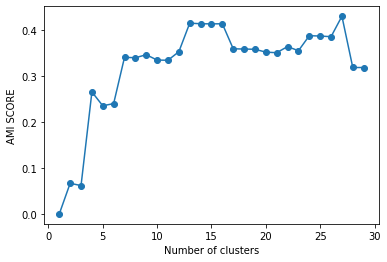

In [50]:
plt.plot(range(1, 30), scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('AMI SCORE')
plt.show()

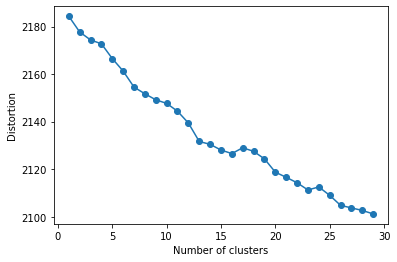

In [51]:
plt.plot(range(1, 30), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

<div dir="rtl">
در نهایت kمناسب را با پیدا کردن مقدار بیشینه ی امتیاز پیدا میکنیم 
</div>

In [53]:
k = np.argmax(scores)
k

26

In [62]:
#fitting kmeans on data with obtained k
NUM_OF_CLUSTERS = k+1
km = KMeans(
    n_clusters=NUM_OF_CLUSTERS, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
predicted_cluster = km.fit_predict(tfidf_mat)

In [63]:
adjusted_mutual_info_score(tag_numbers, predicted_cluster)

0.42945989935776907

<div dir="rtl">
 در نهایت خوشه بندی حاصل را به همراه اطلاعات مستندات در یک فایل csv میریزیم.
</div>

In [64]:
predicted_tfidf = []
for i in range(len(main_page)):
    predicted_tfidf.append({'title':main_page[i].get('title'), 'summary':main_page[i].get('summary'), 'link':main_page[i].get('link'), 'cluster': predicted_cluster[i]})

In [70]:
with open('tfidf_kmeans.csv', 'w', newline='') as tfidf_kmeans:
    fc = csv.DictWriter(tfidf_kmeans, 
                        fieldnames=predicted_tfidf[0].keys(),

                       )
    fc.writeheader()
    fc.writerows(predicted_tfidf)

## clustering using kmeans and word2vec

<div dir="rtl">
 در این بخش میخواهیم با استفاده از مجموعه بردار های word2vec مستندات که در یک ماتریس ریخته ایم خوشه بندی با kmeansرا انجام دهیم.
</div>

<div dir="rtl">
در این بخش برای تعداد k های مختلف خوشه بندی را اجرا میکنیم تا k مناسب را پیدا کنیم برای انتخاب تعداد خوشه های مناسب از دو معیار distortion و adjusted mutual information استفاده میکنیم.
</div>

In [74]:
wv_scores = []
wv_distortions = []
for k in range(1,50):
    NUM_OF_CLUSTERS = k
    km = KMeans(
        n_clusters=NUM_OF_CLUSTERS, init='random',
        n_init=10, max_iter=300, 
        tol=1e-04, random_state=0
    )
    predicted_cluster = km.fit_predict(w2vec_mat)
    wv_distortions.append(km.inertia_)
    wv_scores += [adjusted_mutual_info_score(tag_numbers, predicted_cluster)]

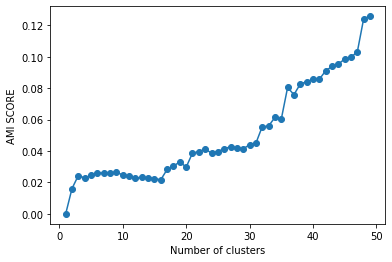

In [75]:
plt.plot(range(1, 50), wv_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('AMI SCORE')
plt.show()

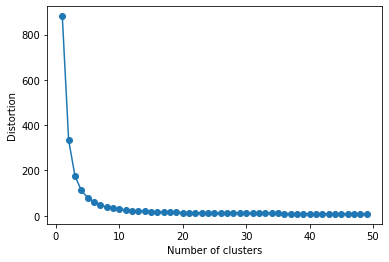

In [76]:
plt.plot(range(1, 50), wv_distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

<div dir="rtl">
همانطورکه در نمودار بالا مشاهده میکنید elbowدر k= 9اتفاق افتاده است برای همین kرا 9 میگیریم.
</div>

In [81]:
#fitting kmeans on data
NUM_OF_CLUSTERS = 9
km = KMeans(
    n_clusters=NUM_OF_CLUSTERS, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
km_w2v = km.fit_predict(w2vec_mat)

In [82]:
adjusted_mutual_info_score(tag_numbers, km_w2v)

0.026384590990882098

<div dir="rtl">
 در نهایت خوشه بندی حاصل را به همراه اطلاعات مستندات در یک فایل csv میریزیم.
</div>

In [85]:
predicted_wv = []
for i in range(len(main_page)):
    predicted_wv.append({'title':main_page[i].get('title'), 'summary':main_page[i].get('summary'),
                         'link':main_page[i].get('link'), 'cluster': km_w2v[i]})

In [86]:
with open('w2vec_kmeans.csv', 'w', newline='') as w2vec_kmeans:
    fc = csv.DictWriter(w2vec_kmeans, 
                        fieldnames=predicted_wv[0].keys(),

                       )
    fc.writeheader()
    fc.writerows(predicted_wv)

## خوشه بندی سلسله مراتبی

<div dir='rtl'> 
حال به خوشه بندی سلسله مراتبی می پردازیم:
    <br>
    در این قسمت ما با امتحان کردن تعداد کلاستر های متفاوت به این نتیجه رسیدیم که ۱۶ کلاستر بهترین نتیجه ها را خواهد داد و پس از آن معیار های ارزیابی کاهش می یابند:
</div>

In [22]:
tfidf_matrix = []
tag_numbers = []
for i in range(len(pages)):
    tfidf_matrix +=[pages[i].get('tfidf_vector')]
    tag_numbers += [pages[i].get('tag_number')]

In [23]:
from sklearn.cluster import AgglomerativeClustering
def hierarchical(pages, n):
    tf_idf = []
#     print(len(pages))
    for i in range(len(pages)):
        tf_idf += [pages[i].get('tfidf_vector')]
    tf_idf2 = np.array(tf_idf) 
    cluster = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    clus=cluster.fit_predict(tf_idf2)
    return clus

clusters = hierarchical(pages,16)

<div dir='rtl'> 
دو معیار ارزیابی AMI و NMI را انتخاب کردیم که پاسخ ها به صورت زیر می باشند:
</div>

In [24]:
adjusted_mutual_info_score (tag_numbers, clusters)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.35556365754305574

In [26]:
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score (tag_numbers, clusters)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.402638464134915

<div dir='rtl'> 
حالا به محاسبه ۲۰ امتیاز اولیه می پردازیم که بعد از آن نمودار را رسم کنیم:
</div>

In [27]:
scores = []
scores1 = []
for i in range(1,20):
    clusters = hierarchical(pages,i)
    scores += [adjusted_mutual_info_score (tag_numbers, clusters)]
    scores1 += [normalized_mutual_info_score (tag_numbers, clusters)]
print(scores)
print(scores1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/cluster/s

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/cluster/s

[-3.1174040314986666e-16, 0.07894930906111398, 0.18033376137852108, 0.23315811283832588, 0.23474639999670824, 0.23473549535712637, 0.24025560736642976, 0.2410011240966124, 0.28411758114597935, 0.28872576857904064, 0.28831993638845677, 0.33589037233026464, 0.3458112478162991, 0.3523708756519617, 0.3548233025363717, 0.35556365754305574, 0.3551514291925462, 0.35549369773607775, 0.3553911356875654]
[-1.1875, 0.18593478151473894, 0.31072174554880067, 0.3592078152113695, 0.36133634935367975, 0.35126047389026865, 0.35014865493830744, 0.3499012990459634, 0.3843929450232634, 0.38094513477127906, 0.38038460061707574, 0.397399784960105, 0.4057180741802434, 0.40742688019939527, 0.40562805110405875, 0.402638464134915, 0.40009316123499905, 0.3993737311277298, 0.3972082375556299]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


<div dir='rtl'> 
نمودار زیر نشان دهنده ی امتیاز ها و تعداد کلاستر ها می باشد که برحسب AMI به دست آمده است:</div>

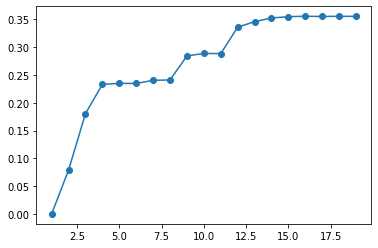

In [28]:
plt.plot(range(1,20), scores, marker='o')

<div dir='rtl'> 
نمودار زیر برحسب NMI می باشد:
</div>

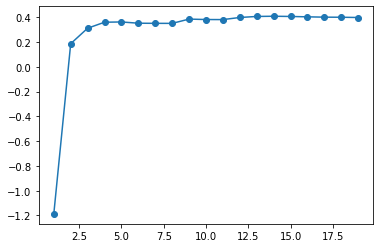

In [29]:
plt.plot(range(1,20), scores1, marker='o')

<div dir='rtl'> 
حال برای word2vec محاسبه میکنیم:
</div>

In [30]:
import gensim
from gensim.models.word2vec import Word2Vec
def w2v_maker(docs): # docs = list of dictionaries
    texts = []
    for d in docs:
        text = d.get('title') + d.get('summary') + d.get("tags")
        texts.append(text)
    print(len(texts))
    return Word2Vec(sentences= texts, size=32, window=10, min_count=0, seed=42, workers=5)

In [31]:
w2vt = w2v_maker(pages)

2203


In [32]:
def vectorize(doc, w2vec_model):
    vec = []
    word_num = 0
    for word in doc:
        if word_num == 0:
            vec = w2vec_model.wv[word]
        else:
            vec = np.add(vec, w2vec_model.wv[word])
        word_num += 1
    return np.asarray(vec)/word_num

In [33]:
w2vec_matrix = []
for i in range(len(pages)):
    text_of_doc = pages[i].get('title') + pages[i].get('summary')+ pages[i].get('tags')
    vec = vectorize(text_of_doc, w2vt)
    w2vec_matrix += [vec]
w2vec_mat = np.array(w2vec_matrix)
w2vec_mat.shape

(2203, 32)

<div dir='rtl'> 
خوشه بندی سلسله مراتبی با word2vec به شکل زیر می باشد:
</div>

In [34]:
cluster = AgglomerativeClustering(n_clusters=16, affinity='euclidean', linkage='ward')
clus=cluster.fit_predict(w2vec_mat)

<div dir='rtl'> 
مانند قبل با دو معیار AMI و NMI خوشه بندی سلسله مراتبی را بررسی کرده ایم و به شکل زیر درآمده است:
</div>

In [35]:
adjusted_mutual_info_score (tag_numbers, clus)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.02666932398842933

In [36]:
normalized_mutual_info_score (tag_numbers, clus)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.047637986148699706

<div dir='rtl'> 
حال در درون csv میریزیم:
</div>

In [39]:
predicted_tfidf1 = []
for i in range(len(main_page)):
    predicted_tfidf1.append({'title':main_page[i].get('title'), 'summary':main_page[i].get('summary'), 'link':main_page[i].get('link'), 'cluster': clusters[i]})

In [41]:
predicted_tfidf1

[{'title': 'پرترافیک\u200cترین جاده\u200cهای ایران پس از پایان ممنوعیت ترددهای بین\u200cاستانی ',
  'summary': 'رئیس مرکز اطلاعات و کنترل ترافیک پلیس راهور ناجا از افزایش ترددها در محورهای مواصلاتی استان کشور در روزهای اول و دوم اردیبهشت خبر داد ',
  'link': 'https://www.hamshahrionline.ir/news/503910/پرترافیک-ترین-جاده-های-ایران-پس-از-پایان-ممنوعیت-ترددهای-بین-استانی',
  'cluster': 5},
 {'title': 'نخستین کاروان حج ششم تیر اعزام می\u200cشود ',
  'summary': 'معاون حج و عمره سازمان حج و زیارت اعلام کرد در صورت عادی شدن شرایط مربوط به شیوع ویروس کرونا، نخستین کاروان زائران حج تمتع ششم تیر امسال\xa0راهی سرزمین وحی خواهند شد ',
  'link': 'https://www.hamshahrionline.ir/news/503441/نخستین-کاروان-حج-۹۹-ششم-تیر-اعزام-می-شود',
  'cluster': 5},
 {'title': 'ممنوعیت ترددهای بین استانی لغو شد ',
  'summary': 'رییس مرکز اطلاعات و کنترل ترافیک پلیس راهور ناجا از لغو ممنوعیت تردد بین\u200cاستانی در سراسر کشور خبر داد ',
  'link': 'https://www.hamshahrionline.ir/news/503002/ممنوعیت-ترددهای-بین-استانی-ل

In [43]:
with open('tfidf_hierarchical.csv', 'w', newline='') as tfidf_hierarchical:
    fc = csv.DictWriter(tfidf_hierarchical, 
                        fieldnames=predicted_tfidf1[0].keys(),

                       )
    fc.writeheader()
    fc.writerows(predicted_tfidf1)

In [44]:
predicted_wv1 = []
for i in range(len(main_page)):
    predicted_wv1.append({'title':main_page[i].get('title'), 'summary':main_page[i].get('summary'),
                         'link':main_page[i].get('link'), 'cluster': clus[i]})

In [45]:
with open('w2vec_hierarchical.csv', 'w', newline='') as w2vec_hierarchical:
    fc = csv.DictWriter(w2vec_hierarchical, 
                        fieldnames=predicted_wv1[0].keys(),

                       )
    fc.writeheader()
    fc.writerows(predicted_wv1)